In [113]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### A) Download and unzip the file apples.zip.

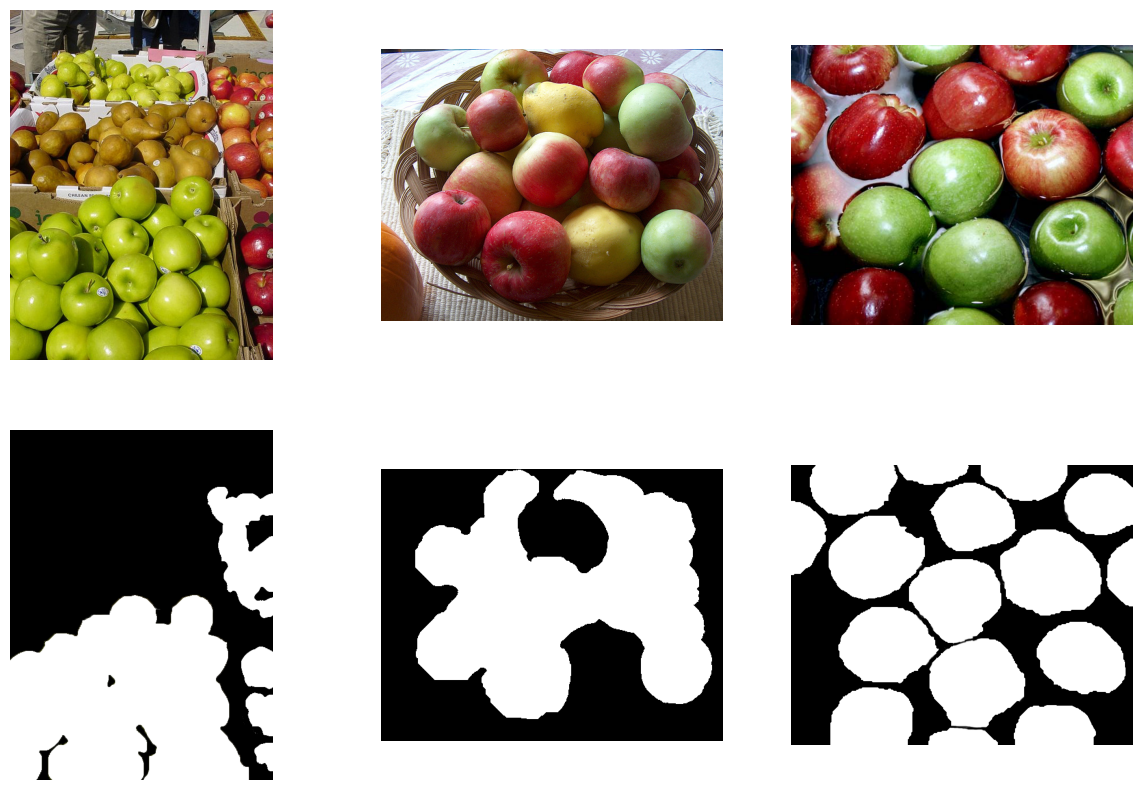

In [114]:
image_list = []
raw_masks = []

# load images
image_files = glob.glob("apples/*.jpg")
image_files.sort()
for cur_img in image_files:
    image = plt.imread(cur_img)
    image_list.append(image)
# load masks
mask_files = glob.glob("apples/*.png")
mask_files.sort()
for cur_mask in mask_files:
    raw = plt.imread(cur_mask)
    if raw.shape[-1] == 4:
        raw = np.delete(raw, -1, axis=-1)
    raw_masks.append(raw)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(len(image_list)):
    axs[i].imshow(image_list[i])
    axs[i+3].imshow(raw_masks[i])
    axs[i].axis('off')
    axs[i+3].axis('off')

plt.show()

In [115]:
def mask_reshape(data):
    return np.float32(data.reshape(data.shape[0] * data.shape[1], data.shape[2]))

num_images = len(image_list)
total_apple_pixels = np.empty((3, 0))
non_apple_pixels = np.empty((3, 0))
for i in range(num_images):
    reshaped_image = mask_reshape(image_list[i])
    reshaped_mask = np.delete(mask_reshape(raw_masks[i]), [1,2], axis=1).squeeze().astype(int)
    cur_apple_pixels = reshaped_image[reshaped_mask > 0].T / 255.0
    cur_non_apple_pixels = reshaped_image[reshaped_mask == 0].T / 255.0
    total_apple_pixels = np.concatenate((total_apple_pixels, cur_apple_pixels), axis=1)
    non_apple_pixels = np.concatenate((non_apple_pixels, cur_non_apple_pixels), axis=1)

print(total_apple_pixels.shape)
print(non_apple_pixels.shape)

(3, 424647)
(3, 375653)


### B) Use mixtures of Gaussians to distinguish apple vs. non-apple pixels. Use red, green, and blue as your dimensions for now. Make any other decisions you need to, and document them in your .ipynb notebook

In [116]:
def multivariate_normal_pdf(x, mu, cov):
    if np.linalg.det(cov) == 0:
        cov += 6e-5 * np.identity(cov.shape[0])
    normal_denominator = 1.0 / np.sqrt(np.power((2 * np.pi), x.shape[1]) * np.linalg.det(cov))
    x_mu = np.matrix(x - mu) # (424647, 3)
    x_mu_dot_inv_cov = x_mu @ np.linalg.inv(cov) # (424647, 3)
    exponent = -0.5 * np.sum(np.multiply(x_mu, x_mu_dot_inv_cov), axis=1)
    return (normal_denominator * np.exp(exponent)).reshape(-1)

def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.

    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    """
    
    data = np.atleast_2d(data)
    # find total number of data items
    nDims, nData = data.shape
                   
    # calculate likelihoods for all data points at once
    likelihoods = np.zeros((mixGaussEst['k'], nData))
    for current_gauss in range(mixGaussEst['k']):
        likelihoods[current_gauss, :] = mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(data.T, mixGaussEst['mean'][:, current_gauss], mixGaussEst['cov'][:, :, current_gauss])
    
    logLike = np.sum(np.log(np.sum(likelihoods, axis=0)))
    
    return logLike

In [117]:
def fitMixGauss(data, k):
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))

    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    nIter = 30
    for cIter in range(nIter):
        # ===================== =====================
        # Expectation step
        for current_gauss in range(k):
            postHidden[current_gauss, :] = mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(data.T, mixGaussEst['mean'][:, current_gauss], mixGaussEst['cov'][:, :, current_gauss])
        postHidden = postHidden / np.sum(postHidden, axis=0)

        # ===================== =====================
        # Maximization Step
        for cGauss in range(k):
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:]) / np.sum(postHidden)
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss,:] * data, axis=1) / np.sum(postHidden[cGauss,:])
            
            data_diff = data - mixGaussEst['mean'][:, cGauss][:, np.newaxis]
            mixGaussEst['cov'][:, :, cGauss] = np.dot(data_diff * postHidden[cGauss, :], data_diff.T) / np.sum(postHidden[cGauss, :])

        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

In [118]:
# Train
nGaussEst = 6
apple_mog_estimated = fitMixGauss(total_apple_pixels, nGaussEst)
non_apple_mog_estimated = fitMixGauss(non_apple_pixels, nGaussEst)

Log Likelihood Iter 0 : -2436666.638

Log Likelihood After Iter 0 : 288717.444

Log Likelihood After Iter 1 : 303122.037

Log Likelihood After Iter 2 : 348197.214

Log Likelihood After Iter 3 : 495809.894

Log Likelihood After Iter 4 : 647807.185

Log Likelihood After Iter 5 : 712125.290

Log Likelihood After Iter 6 : 763641.336

Log Likelihood After Iter 7 : 805803.957

Log Likelihood After Iter 8 : 832838.816

Log Likelihood After Iter 9 : 852206.766

Log Likelihood After Iter 10 : 870034.159

Log Likelihood After Iter 11 : 885991.181

Log Likelihood After Iter 12 : 896317.765

Log Likelihood After Iter 13 : 901172.385

Log Likelihood After Iter 14 : 903446.496

Log Likelihood After Iter 15 : 904634.178

Log Likelihood After Iter 16 : 905330.354

Log Likelihood After Iter 17 : 905785.558

Log Likelihood After Iter 18 : 906109.099

Log Likelihood After Iter 19 : 906352.091

Log Likelihood After Iter 20 : 906541.528

Log Likelihood After Iter 21 : 906693.491

Log Likelihood After Iter 

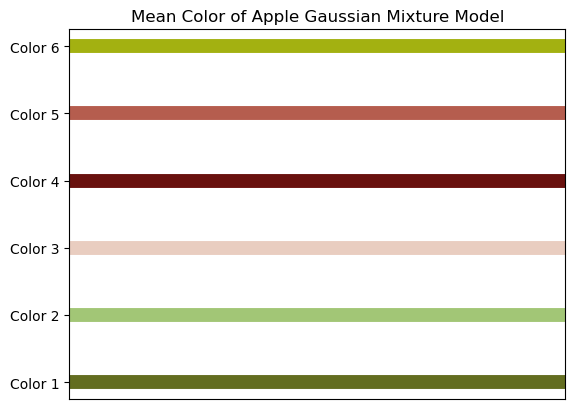

In [119]:
# Mean Color of Apple Gaussian Mixture Model
rgb_color_mog_mean = apple_mog_estimated['mean'].T
fig, ax = plt.subplots()
for i in range(len(rgb_color_mog_mean)):
    ax.axhline(i, color=rgb_color_mog_mean[i], linewidth=10)

ax.set_yticks(range(len(rgb_color_mog_mean)))
ax.set_yticklabels([f"Color {i+1}" for i in range(len(rgb_color_mog_mean))])
ax.set_xticks([])
ax.set_title("Mean Color of Apple Gaussian Mixture Model")
plt.show()

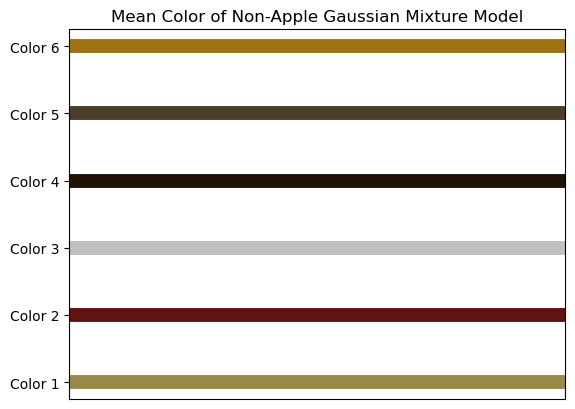

In [120]:
# Mean Color of Non-Apple Gaussian Mixture Model
rgb_color_mog_mean = non_apple_mog_estimated['mean'].T
fig, ax = plt.subplots()
for i in range(len(rgb_color_mog_mean)):
    ax.axhline(i, color=rgb_color_mog_mean[i], linewidth=10)

ax.set_yticks(range(len(rgb_color_mog_mean)))
ax.set_yticklabels([f"Color {i+1}" for i in range(len(rgb_color_mog_mean))])
ax.set_xticks([])
ax.set_title("Mean Color of Non-Apple Gaussian Mixture Model")
plt.show()

### C) Download the file testApples.zip. Generate figures for your notebook, showing each pixel’s posterior probability of being “apple.” Comment on the outcomes

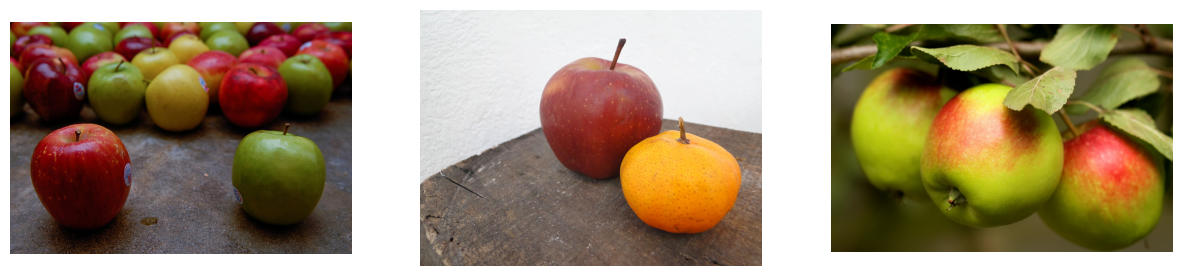

In [121]:
test_images_list = []

# load test images
test_image_files = glob.glob("testApples/*.jpg")
test_image_files.sort()
for cur_img in test_image_files:
    image = plt.imread(cur_img)
    test_images_list.append(image)

# show test images
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.flatten()
for i in range(len(test_images_list)):
    axs[i].imshow(test_images_list[i])
    axs[i].axis('off')

plt.show()

In [134]:
def inference_mask(image_data, apple_mixGaussEst, non_apple_mixGaussEst, threshold=0.5, prior_apple=0.5):
    original_shape = image_data.shape
    image_data = mask_reshape(image_data).T / 255.0
    nDims, nData = image_data.shape
    apple_likelihood = np.zeros((apple_mixGaussEst['k'], nData))
    for current_gauss in range(apple_mixGaussEst['k']):
        apple_likelihood[current_gauss, :] = apple_mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(image_data.T, apple_mixGaussEst['mean'][:, current_gauss], apple_mixGaussEst['cov'][:, :, current_gauss])
    apple_mask = np.sum(apple_likelihood, axis=0).reshape(original_shape[0], original_shape[1])

    non_apple_likelihood = np.zeros((non_apple_mixGaussEst['k'], nData))
    for current_gauss in range(non_apple_mixGaussEst['k']):
        non_apple_likelihood[current_gauss, :] = non_apple_mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(image_data.T, non_apple_mixGaussEst['mean'][:, current_gauss], non_apple_mixGaussEst['cov'][:, :, current_gauss])
    non_apple_mask = np.sum(non_apple_likelihood, axis=0).reshape(original_shape[0], original_shape[1])

    prior_non_apple = 1 - prior_apple
    posterior_apple = (apple_mask * prior_apple) / ((apple_mask * prior_apple) + (non_apple_mask * prior_non_apple)) > threshold
    
    return posterior_apple

In [131]:
test_inferences = []
for cur_img in test_images_list:
    test_inferences.append(inference_mask(cur_img, apple_mog_estimated, non_apple_mog_estimated))


(3, 278400)
(3, 3000000)
(3, 1749600)


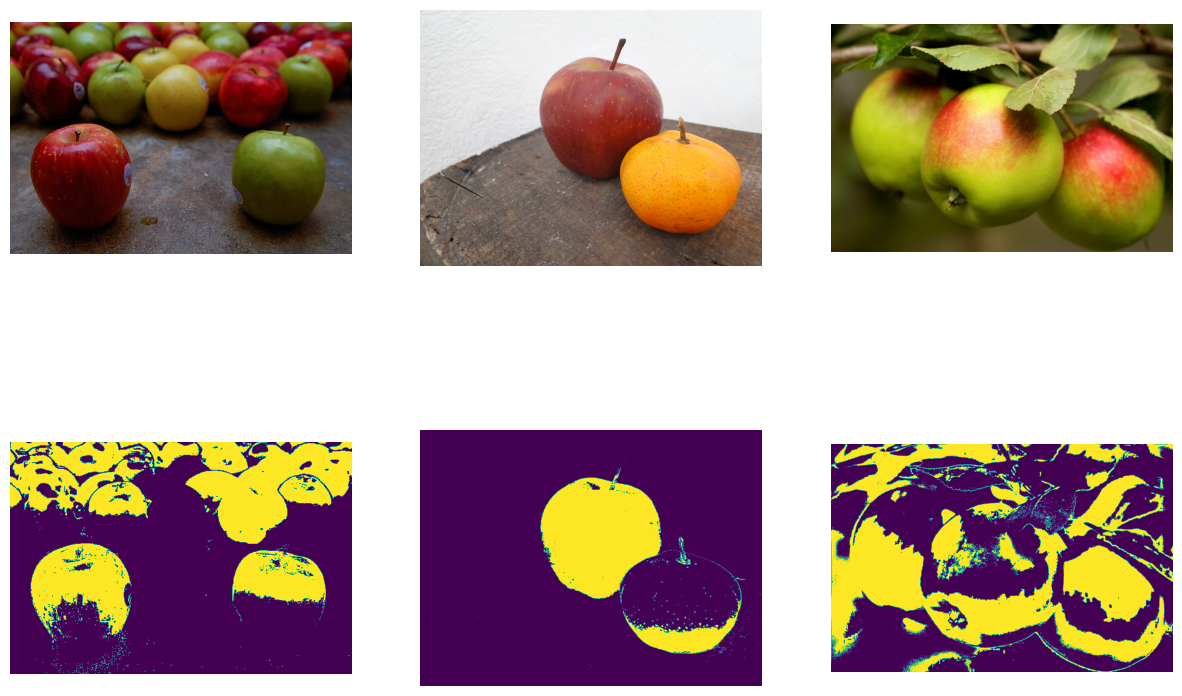

In [132]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(len(test_images_list)):
    axs[i].imshow(test_images_list[i])
    axs[i+3].imshow(test_inferences[i])
    axs[i].axis('off')
    axs[i+3].axis('off')

plt.show()


### D) For the test image with a ground-truth mask, quantify and report your result.
Hint:
consider applying a range of thresholds to the posterior to produce sets of {True Positives
(TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)} and using an
ROC curve. Learn about ROC on Wikipedia or see Peter Flach’s chapter on the subject

(3, 3000000)


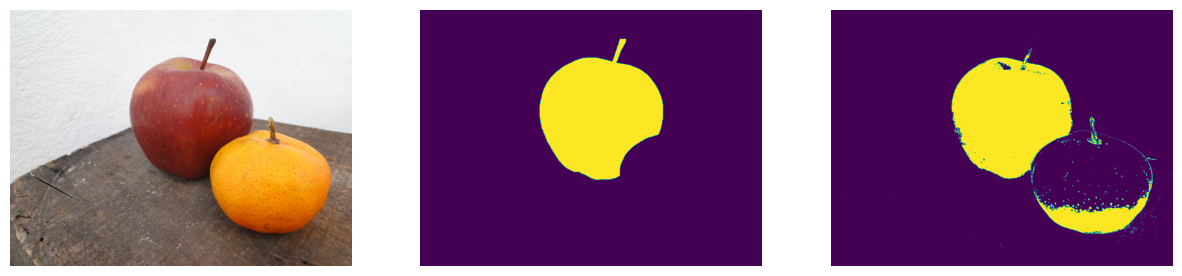

In [125]:
# Read the image Bbr98ad4z0A-ctgXo3gdwu8-original.jpg from testApples folder
test_image_with_gt = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg')
test_gt_mask = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')
test_gt_mask = np.delete(test_gt_mask, [1,2], axis=2).squeeze().astype(int)
test_with_gt_inference = inference_mask(test_image_with_gt, apple_mog_estimated, non_apple_mog_estimated)

show_images = [test_image_with_gt, test_gt_mask, test_with_gt_inference]
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.flatten()
for i in range(len(show_images)):
    axs[i].imshow(show_images[i])
    axs[i].axis('off')

plt.show()


In [142]:
threshold_list = np.linspace(0, 1, 20)
roc_list = []
tpr_list = []
fpr_list = []
for threshold in threshold_list:
    print(f"Threshold: {threshold}")
    test_with_gt_inference = inference_mask(test_image_with_gt, apple_mog_estimated, non_apple_mog_estimated, threshold)

    true_pos = np.sum(np.logical_and(test_gt_mask, test_with_gt_inference))
    true_neg = np.sum(np.logical_and(np.logical_not(test_gt_mask), np.logical_not(test_with_gt_inference)))
    false_pos = np.sum(np.logical_and(np.logical_not(test_gt_mask), test_with_gt_inference))
    false_neg = np.sum(np.logical_and(test_gt_mask, np.logical_not(test_with_gt_inference)))

    # calculate roc
    tpr = true_pos / (true_pos + false_neg)
    fpr = false_pos / (false_pos + true_neg)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    roc_list.append([tpr, fpr])

Threshold: 0.0
Threshold: 0.05263157894736842
Threshold: 0.10526315789473684
Threshold: 0.15789473684210525
Threshold: 0.21052631578947367
Threshold: 0.2631578947368421
Threshold: 0.3157894736842105
Threshold: 0.3684210526315789
Threshold: 0.42105263157894735
Threshold: 0.47368421052631576
Threshold: 0.5263157894736842
Threshold: 0.5789473684210527
Threshold: 0.631578947368421
Threshold: 0.6842105263157894
Threshold: 0.7368421052631579
Threshold: 0.7894736842105263
Threshold: 0.8421052631578947
Threshold: 0.894736842105263
Threshold: 0.9473684210526315
Threshold: 1.0


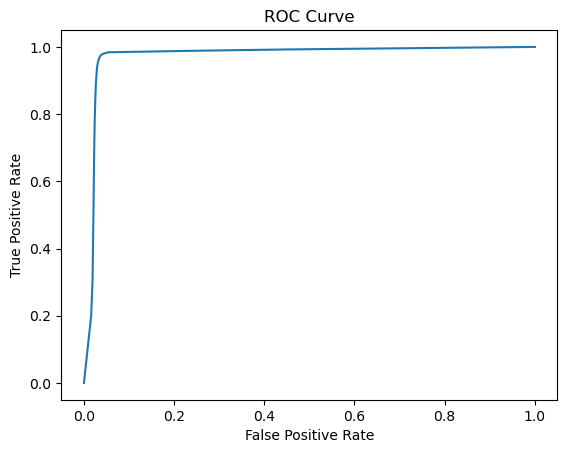

AUC (Area): -0.9732604069446456
AUC (sklearn): 0.9732604069446456


In [149]:
# Plot ROC Curve
roc_list = np.array(roc_list)
plt.plot(roc_list[:, 1], roc_list[:, 0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Calculate AUC with 2 methods to check
auc = np.trapz(roc_list[:, 0], roc_list[:, 1])
print(f"AUC (Area): {auc}")

from sklearn.metrics import roc_curve, auc
roc_auc = auc(fpr_list, tpr_list)
print(f"AUC (sklearn): {roc_auc}")


### E) Download or snap two non-copyrighted photos with apples 
(maybe http://search.creativecommons.org/ or some other source of images that are not copyrighted).
Make good ground-truth masks for them. You can use Windows Paint, or more sophisticated
programs like Gimp (free). Use these as extra test-images. Report your qualitative and
quantitative results.

### F) We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why